In [1]:
'''
Explore design choices in baseline second-order MAML
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings
import importlib

warnings.filterwarnings("ignore")

seed = 0 # set seed for reproducibility

#Set random seeds for reproducibility of results 
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

# import backbone model, dataset, and code utils
from models import Neural_Network
from constants import *
from utils import *
import analysis_utils
from data import *



Available device: cpu
Available device: cpu


In [2]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

Iter =  0  Current Loss 3.243267297744751  Val Loss:  9.623868942260742
Iter =  2500  Current Loss 3.2665293516039324  Val Loss:  3.0051543132701024
Iter =  5000  Current Loss 2.961651152740643  Val Loss:  2.740902254894641
Iter =  7500  Current Loss 2.7490517221725934  Val Loss:  2.5635919443569675
shape:  (1000, 11)
Step: 0, Error: 3.1828194572106003, Var: 5.662387192574472
Step: 1, Error: 1.6076086069494486, Var: 1.736320463226523
Step: 5, Error: 1.5052304340717382, Var: 3.0024889975037663
Iter =  0  Current Loss 5.17879581451416  Val Loss:  13.171504020690918
Iter =  2500  Current Loss 2.1921837359416583  Val Loss:  2.0967917913285756
Iter =  5000  Current Loss 1.5864332450482637  Val Loss:  1.4920899986262066
Iter =  7500  Current Loss 1.3295855407412251  Val Loss:  1.2300115222802417
shape:  (1000, 11)
Step: 0, Error: 3.0025663413489236, Var: 5.236876148753596
Step: 1, Error: 0.4646091848602518, Var: 0.1485568113590122
Step: 5, Error: 0.10049283195624593, Var: 0.02821560955030319

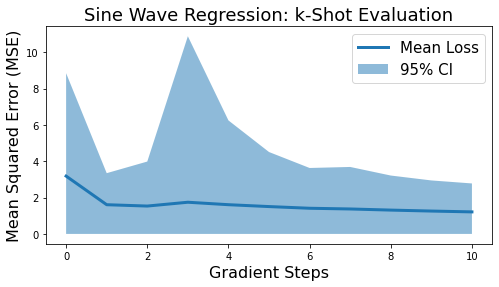

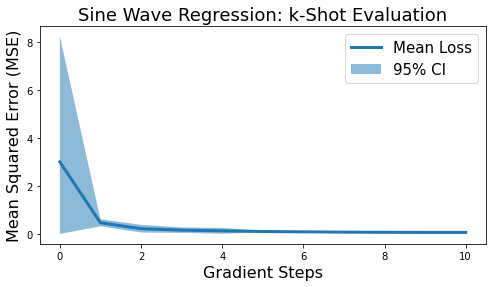

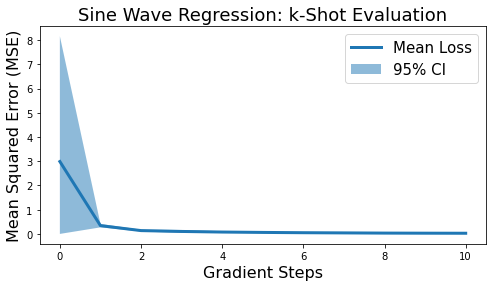

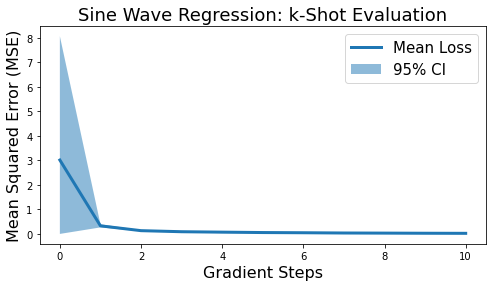

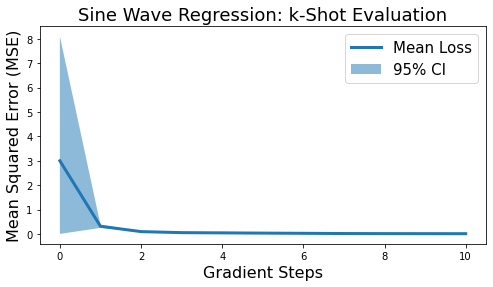

In [3]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

hidden_sizes = [5, 15, 40, 75, 150]

N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
K = 10 # number of samples to draw from the task

num_epochs = 10000

num_k_shots = 11
num_eval=1000

printing_step = 2500

for hidden_size in hidden_sizes: 

    #Instantiate the model network
    model = Neural_Network(hidden_size = hidden_size)
    # move to the current device (GPU or CPU)
    # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
    model.to(device)

    #Used to store the validation losses
    metaLosses = []
    metaValLosses = []

    #Meta-optimizer for the outer loop
    meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

    #Inner optimizer, we were doing this by hand previously
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # store loss over all tasks to then do a large meta-level update of initial params
        # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
        meta_loss = None

        waves = dataset.get_meta_train_batch(task_batch_size=T)

        #Loop through all of the tasks
        for i, T_i in enumerate(waves): 
            train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
            held_out_task_specific_loss = train_eval_info[0]
            if meta_loss is None: 
                meta_loss = held_out_task_specific_loss
            else:
                meta_loss += held_out_task_specific_loss

        meta_optimizer.zero_grad()
        meta_loss /= T
        meta_loss.backward()
        meta_optimizer.step()
        metaLosses.append(meta_loss.item())

        # validation 
        val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
        val_train_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
        val_loss = val_train_eval_info[0]
        metaValLosses.append(val_loss.item())

        if epoch % printing_step == 0:
            print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
            # saving model help from: 
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), f"baseline_maml_hidden_{hidden_size}.pt")


    res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                            file_tag=f"baseline_maml_hidden_{hidden_size}.pdf", seed=7)      
        